In [646]:
from Literal import Literal
from Rule import Rule
from Argument import Argument

import matplotlib.pyplot as plt
import networkx as nx

Declaration and display of basic rules :

In [647]:
rules = []
rules.append(Rule([], Literal("a", False), False, 99, Literal("r1", False)))
rules.append(Rule([Literal("b", False), Literal("d", False)], Literal("c", False), False, 99, Literal("r2", False)))
rules.append(Rule([Literal("c", True)], Literal("d", False), False, 99, Literal("r3", False)))
rules.append(Rule([Literal("a", False)], Literal("d", True), True, 0, Literal("r4", False)))
rules.append(Rule([], Literal("b", False), True, 1, Literal("r5", False)))
rules.append(Rule([], Literal("c", True), True, 1, Literal("r6", False)))
rules.append(Rule([], Literal("d", False), True, 0, Literal("r7", False)))
rules.append(Rule([Literal("c", False)], Literal("e", False), True, 0, Literal("r8", False)))
rules.append(Rule([Literal("c", True)], Literal("r4", True), True, 0, Literal("r9", False)))

# Print the rules
for rule in rules:
    rule.print()

r1 :  -> a
r2 : b, d -> c
r3 : ¬c -> d
r4 : a => ¬d 0
r5 :  => b 1
r6 :  => ¬c 1
r7 :  => d 0
r8 : c => e 0
r9 : ¬c => ¬r4 0


Creation of a function that performs the contrapositive of the strict rules :

In [648]:
def contraposition(rule):
    new_rules = []
    # If the rule is not defeasible and has premises
    if not rule.get_is_defeasible() and len(rule.get_premises()) > 0:
        # Visit each premise
        for i, _ in enumerate(rule.get_premises()):
            # Create a new rule with the premise as conclusion and the conclusion as premise with the others premises
            new_premises = list(rule.get_premises())
            new_premises.pop(i)
            new_premises.append(Literal(rule.get_conclusion().get_value(), not rule.get_conclusion().get_is_negative()))
            f = rule.get_reference().get_value() + "c" + str(i + 1)
            new_rule = Rule(new_premises, Literal(rule.get_premises()[i].get_value(), not rule.get_premises()[i].get_is_negative()), False, rule.get_weight(), Literal(f, False))
            new_rules.append(new_rule)
    return new_rules

Displaying rules and their contrapositives :

In [649]:
total_rules = list(rules)
for rule in rules:
    new_rules = contraposition(rule)
    for new_rule in new_rules:
        total_rules.append(new_rule)

for rule in total_rules:
    rule.print()
print()

r1 :  -> a
r2 : b, d -> c
r3 : ¬c -> d
r4 : a => ¬d 0
r5 :  => b 1
r6 :  => ¬c 1
r7 :  => d 0
r8 : c => e 0
r9 : ¬c => ¬r4 0
r2c1 : d, ¬c -> ¬b
r2c2 : b, ¬c -> ¬d
r3c1 : ¬d -> c



Function for creating arguments from rules :

In [650]:
def create_arguments(total_rules):
    arguments = []
    rules = list(total_rules) # list of Rule to be processed
    remaining_rules = list(rules) # list of Rule to be processed
    new_argument_created = True
    
    # While there are rules to be processed and a new argument has been created in the last iteration
    while (len(remaining_rules) > 0 and new_argument_created):
        new_argument_created = False      
        for i, rule in enumerate(remaining_rules):
            # If the rule has no premises, create a new argument
            if len(rule.get_premises()) == 0:
                name = "A" + str(len(arguments) + 1)
                print("Argument created: " + name + " 1")
                argument = Argument(rule, [], name)
                arguments.append(argument)
                rules.remove(rule)
                new_argument_created = True
                
        for i, rule in enumerate(remaining_rules):
            # If the rule has premises
            if len(rule.get_premises()) > 0:
                sub_arguments = []
                # Find the sub-arguments which can be used to create a new argument
                for premise in rule.get_premises():
                    for argument in arguments:
                        print(argument.get_top_rule().get_conclusion().to_string() + " " + premise.to_string())

                        if argument.get_top_rule().get_conclusion() == premise:
                            sub_arguments.append(argument)
                
                nb_premises = len(rule.get_premises())
                # If the rule has one premise
                print("Rule: " + rule.get_reference().get_value() + " Premises: " + str(nb_premises))
                if(nb_premises == 1):
                    found = False
                    # Create a new argument if the sub-argument is not found in a argument for the current rule
                    for sub_argument in sub_arguments:
                        for argument in arguments:
                            if argument.get_top_rule() == rule:
                                # Check if the sub-argument is already in an sub-argument for the current rule
                                for sub in argument.get_sub_arguments():
                                    if sub_argument == sub:
                                        found = True
                                        break

                        if not found:
                            name = "A" + str(len(arguments) + 1)
                            print("Argument created: " + name + " 2")
                            argument = Argument(rule,[sub_argument], name)
                            arguments.append(argument)
                            new_argument_created = True
                        found = False
                            
                # If the rule has two premises
                elif(nb_premises == 2):
                    found = False
                    print("Sub-arguments: " + str(len(sub_arguments)))
                    # Create a new argument if the 2 sub-arguments are not found in a same argument for the current rule
                    for i in range(0, len(sub_arguments)):
                        for j in range(0, len(sub_arguments)):
                            if(sub_arguments[i].get_top_rule().get_conclusion() != sub_arguments[j].get_top_rule().get_conclusion()):
                                print("ici")
                                for argument in arguments:
                                    if argument.get_top_rule() == rule:
                                        # Check if the 2 sub-arguments are already sub-arguments in an argument for the current rule
                                        for sub in argument.get_sub_arguments():
                                            for sub2 in argument.get_sub_arguments():
                                                if sub != sub2:
                                                    if (sub_arguments[i] == sub and sub_arguments[j] == sub2) or (sub_arguments[i] == sub2 and sub_arguments[j] == sub):
                                                        found = True
                                                        break
                                                        
                                if not found :
                                    print('la')
                                    name = "A" + str(len(arguments) + 1)
                                    print("Argument created: " + name + " 3")
                                    argument = Argument(rule, [sub_arguments[i], sub_arguments[j]], name)
                                    arguments.append(argument)
                                    new_argument_created = True
                                found = False
                        
        remaining_rules = list(rules)
        
    return arguments

Display of generated arguments :

In [651]:
arguments = create_arguments(total_rules)
for argument in arguments:
    argument.print()

Argument created: A1 1
Argument created: A2 1
Argument created: A3 1
Argument created: A4 1
a b
b b
¬c b
d b
a d
b d
¬c d
d d
Rule: r2 Premises: 2
Sub-arguments: 2
ici
la
Argument created: A5 3
ici
a ¬c
b ¬c
¬c ¬c
d ¬c
c ¬c
Rule: r3 Premises: 1
Argument created: A6 2
a a
b a
¬c a
d a
c a
d a
Rule: r4 Premises: 1
Argument created: A7 2
a c
b c
¬c c
d c
c c
d c
¬d c
Rule: r8 Premises: 1
Argument created: A8 2
a ¬c
b ¬c
¬c ¬c
d ¬c
c ¬c
d ¬c
¬d ¬c
e ¬c
Rule: r9 Premises: 1
Argument created: A9 2
a d
b d
¬c d
d d
c d
d d
¬d d
e d
¬r4 d
a ¬c
b ¬c
¬c ¬c
d ¬c
c ¬c
d ¬c
¬d ¬c
e ¬c
¬r4 ¬c
Rule: r2c1 Premises: 2
Sub-arguments: 3
ici
la
Argument created: A10 3
ici
la
Argument created: A11 3
ici
ici
a b
b b
¬c b
d b
c b
d b
¬d b
e b
¬r4 b
¬b b
¬b b
a ¬c
b ¬c
¬c ¬c
d ¬c
c ¬c
d ¬c
¬d ¬c
e ¬c
¬r4 ¬c
¬b ¬c
¬b ¬c
Rule: r2c2 Premises: 2
Sub-arguments: 2
ici
la
Argument created: A12 3
ici
a ¬d
b ¬d
¬c ¬d
d ¬d
c ¬d
d ¬d
¬d ¬d
e ¬d
¬r4 ¬d
¬b ¬d
¬b ¬d
¬d ¬d
Rule: r3c1 Premises: 1
Argument created: A13 2
Argu

Display arguments with a list of their undoable rules, a list of their last undoable rules and a list of their sub-arguments:

In [652]:
for argument in arguments:
    argument.print()
    
    defeasible_rules = argument.get_defeasible_rules()
    print("Defeasible rules of " + argument.get_name() + ":", end=" ")
    for i, rule in enumerate(defeasible_rules):
        print(rule.get_reference().get_value(), end="")
        if i < len(defeasible_rules) - 1:
            print(",", end="")  
    print()   
    
    last_defeasible_rules = argument.get_last_defeasible_rules()
    print("Last defeasible rules of " + argument.get_name() + ":" , end=" ")
    for i, rule in enumerate(last_defeasible_rules):
        print(rule.get_reference().get_value(), end="")
        if i < len(last_defeasible_rules) - 1:
            print(",", end="")
    print()
        
    sub_arguments = argument.get_sub_arguments()
    print("Sub-arguments of " + argument.get_name() + ":" , end=" ")
    for sub_argument in sub_arguments:
        print(sub_argument.get_name(), end="")
        if sub_argument != sub_arguments[-1]:
            print(",", end="")

    print("\n")

A1 :  -> a
Defeasible rules of A1: 
Last defeasible rules of A1: 
Sub-arguments of A1: 

A2 :  => b
Defeasible rules of A2: r5
Last defeasible rules of A2: r5
Sub-arguments of A2: 

A3 :  => ¬c
Defeasible rules of A3: r6
Last defeasible rules of A3: r6
Sub-arguments of A3: 

A4 :  => d
Defeasible rules of A4: r7
Last defeasible rules of A4: r7
Sub-arguments of A4: 

A5 : A2,A4 -> c
Defeasible rules of A5: r5,r7
Last defeasible rules of A5: r5,r7
Sub-arguments of A5: A2,A4

A6 : A3 -> d
Defeasible rules of A6: r6
Last defeasible rules of A6: r6
Sub-arguments of A6: A3

A7 : A1 => ¬d
Defeasible rules of A7: r4
Last defeasible rules of A7: r4
Sub-arguments of A7: A1

A8 : A5 => e
Defeasible rules of A8: r8,r5,r7
Last defeasible rules of A8: r8
Sub-arguments of A8: A5

A9 : A3 => ¬r4
Defeasible rules of A9: r9,r6
Last defeasible rules of A9: r9
Sub-arguments of A9: A3

A10 : A4,A3 -> ¬b
Defeasible rules of A10: r7,r6
Last defeasible rules of A10: r7,r6
Sub-arguments of A10: A4,A3

A11 : A6

Function used to generate undercuts in relation to arguments :

In [653]:
def generate_undercuts(arguments):
    attackers = []
    undercuts = []
    
    # Get the attackers
    for argument in arguments:
        conclusion = argument.get_top_rule().get_conclusion()
        # Check if the conclusion is the negation of a rule
        if "r" in conclusion.get_value() and conclusion.get_is_negative():
            attackers.append(argument)

    # Find the undercuts
    for attacker in attackers:
        for argument in arguments:
            # Check if the attacker's conclusion is the argument's top rule's 
            if argument.get_top_rule().get_reference().get_value() == attacker.get_top_rule().get_conclusion().get_value():
                undercuts.append([attacker.get_name(), argument.get_name()])
            else :
                # Find if a sub-argument be part of the attacked arguments
                for sub_argument in argument.get_sub_arguments():
                    for i, _ in enumerate(undercuts):
                        # Chek if the sub-argument is already in the undercuts list
                        if undercuts[i][0] == attacker.get_name() and undercuts[i][1] == sub_argument.get_name():
                            undercuts.append([attacker.get_name(), argument.get_name()])
                            break
          
    # Print the undercuts
    for i, _ in enumerate(undercuts):
        print("(" + undercuts[i][0] + "," + undercuts[i][1] + ")" , end=" ")
        
    print("\n")
        
    return undercuts

Display of generated undercuts :

In [654]:
undercuts = generate_undercuts(arguments)

(A9,A7) (A9,A13) (A9,A16) 



Function used to generate rebuttals in relation to the arguments :

In [655]:
def generate_rebuts(arguments):
    rebuts = []
    
    for argument in arguments:
        for argument2 in arguments:
            # Check if the argument's conclusion is the negation of the argument2's conclusion
            if (argument.get_top_rule().get_conclusion().get_value() == argument2.get_top_rule().get_conclusion().get_value() and 
            argument.get_top_rule().get_conclusion().get_is_negative() != argument2.get_top_rule().get_conclusion().get_is_negative()):
                rebuts.append([argument.get_name(), argument2.get_name()])
            else :
                # Find if a sub-argument of argument2 be part of the attacked arguments
                for sub_argument in argument2.get_sub_arguments():
                    for i, _ in enumerate(rebuts):
                        # Check if the sub-argument is already attacked by the argument 
                        if rebuts[i][0] == argument.get_name() and rebuts[i][1] == sub_argument.get_name():
                            # Check duplicates
                            if [argument.get_name(), argument2.get_name()] not in rebuts:
                                rebuts.append([argument.get_name(), argument2.get_name()])
                                break
                        
    # Print the rebuts
    attacker = 1
    print("Number of rebuts: " + str(len(rebuts)))
    for i, _ in enumerate(rebuts):
        number = rebuts[i][0][1:]
        if int(number) > attacker:
            attacker = int(number)
            print()
        print("(" + rebuts[i][0] + "," + rebuts[i][1] + ")" , end=" ")
    print("\n")
        
    return rebuts

Display of rebuts generated :

In [656]:
rebuts = generate_rebuts(arguments)

Number of rebuts: 94

(A2,A10) (A2,A11) 
(A3,A5) (A3,A8) (A3,A13) (A3,A14) (A3,A15) (A3,A16) (A3,A17) (A3,A18) 
(A4,A7) (A4,A12) (A4,A13) (A4,A14) (A4,A16) (A4,A17) 
(A5,A3) (A5,A6) (A5,A9) (A5,A10) (A5,A11) (A5,A12) (A5,A14) (A5,A15) (A5,A17) (A5,A18) 
(A6,A7) (A6,A12) (A6,A13) (A6,A14) (A6,A16) (A6,A17) 
(A7,A4) (A7,A5) (A7,A6) (A7,A8) (A7,A10) (A7,A11) (A7,A15) (A7,A18) 
(A10,A2) (A10,A5) (A10,A8) (A10,A12) (A10,A14) (A10,A15) (A10,A17) (A10,A18) 
(A11,A2) (A11,A5) (A11,A8) (A11,A12) (A11,A14) (A11,A15) (A11,A17) (A11,A18) 
(A12,A4) (A12,A5) (A12,A6) (A12,A8) (A12,A10) (A12,A11) (A12,A15) (A12,A18) 
(A13,A3) (A13,A6) (A13,A9) (A13,A10) (A13,A11) (A13,A12) (A13,A14) (A13,A15) (A13,A17) (A13,A18) 
(A14,A3) (A14,A6) (A14,A9) (A14,A10) (A14,A11) (A14,A12) (A14,A14) (A14,A15) (A14,A17) (A14,A18) 
(A15,A3) (A15,A6) (A15,A9) (A15,A10) (A15,A11) (A15,A12) (A15,A14) (A15,A15) (A15,A17) (A15,A18) 



Representation of preferences between rules :

In [657]:
preferred_rules = {}
for rule in total_rules:
    preferred_rules[rule.get_reference().get_value()] = rule.get_weight()
    
for rule in preferred_rules:
    print(rule + ":", preferred_rules[rule])

r1: 99
r2: 99
r3: 99
r4: 0
r5: 1
r6: 1
r7: 0
r8: 0
r9: 0
r2c1: 99
r2c2: 99
r3c1: 99


Create a function to compare arguments. To do this, we use a function to obtain the strongest rule for an argument and a function to obtain the weakest rule for an argument:

In [658]:
def best_rule(rules, preferred_rules):
    best_priority = 0
    for rule in rules:
        priority_rule = preferred_rules[rule.get_reference().get_value()]
        if priority_rule > best_priority:
            best_priority = priority_rule
    return best_priority

def worst_rule(rules, preferred_rules):
    worst_priority = 99999
    for rule in rules:
        priority_rule = preferred_rules[rule.get_reference().get_value()]
        if priority_rule < worst_priority:
            worst_priority = priority_rule
    return worst_priority

def compare_arguments(arguments,preferred_rules,principle,link_principle):
    preferred_arguments = {}
    priorityArgument = 0
           
    for argument in arguments:
        # Place the arguments without defeasible rule in the preferred arguments 
        if argument.get_defeasible_rules() == []:
            preferred_arguments[argument.get_name()] = 99
        
        # Place the arguments with defeasible rules in the preferred arguments
        else:
            match link_principle:
                # In the case of the Weakest Link principle, we get the defeasible rules of the argument
                case "Weakest Link":
                    defeasible_rules = argument.get_defeasible_rules()
                    match principle:
                        # In the case of the Elitist principle, the argument take the priority of the best rule
                        case "Elitist":
                            priorityArgument = best_rule(defeasible_rules, preferred_rules)
                        # In the case of the Democratic principle, the argument take the priority of the worst rule
                        case "Democratic":
                            priorityArgument = worst_rule(defeasible_rules, preferred_rules)
                    
                # In the case of the Last Link principle, we get the last defeasible rules of the argument
                case "Last Link":
                    last_defeasible_rules = argument.get_last_defeasible_rules()
                    match principle:
                        # In the case of the Elitist principle, the argument take the priority of the best rule
                        case "Elitist":
                            priorityArgument = best_rule(last_defeasible_rules, preferred_rules)
                        # In the case of the Democratic principle, the argument take the priority of the worst rule
                        case "Democratic":
                            priorityArgument = worst_rule(last_defeasible_rules, preferred_rules)
                            print(priorityArgument)
                                    
            preferred_arguments[argument.get_name()] = priorityArgument
        
    # Print in order of priority 
    for i in range(99,-1,-1):
        has_print = False           
        for argument in preferred_arguments:
            if preferred_arguments[argument] == i:
                print(argument, end=" ")
                has_print = True
        if i > 0 and has_print:
            print(">", end=" ")
    print("\n")
        
    return preferred_arguments

Representation of preferences between arguments :

In [659]:
principle = "Democratic" # Elitist, Democratic
link_principle = "Last Link" # Last Link, Weakest Link
preferred_arguments = compare_arguments(arguments,preferred_rules,principle,link_principle)

aaaaaaaaa
aaaaaaaaa
aaaaaaaaa
aaaaaaaaa
aaaaaaaaa
aaaaaaaaa
aaaaaaaaa
aaaaaaaaa
aaaaaaaaa
aaaaaaaaa
aaaaaaaaa
aaaaaaaaa
aaaaaaaaa
aaaaaaaaa
aaaaaaaaa
aaaaaaaaa
aaaaaaaaa
A1 > A2 A3 A4 A5 A6 A7 A8 A9 A10 A11 A12 A13 A14 A15 A16 A17 A18 



Function for generating defeats :

In [660]:
def generate_defeats(arguments, rebuts, preferred_arguments):
    defeats = []
    match principle:
        case "Elitist":
            for rebut in rebuts:
                # Check if the attacker is in the preferred arguments
                if preferred_arguments[rebut[0]] >= preferred_arguments[rebut[1]]:
                    defeats.append(rebut)
                else:
                    # Check if the attacker argument has aleady a defeat in a sub-argument of the attacked argument
                    for argument in arguments:
                        if argument.get_name() == rebut[1]:
                            for sub_argument in argument.get_sub_arguments():
                                for defeat in defeats:
                                    if defeat[0] == rebut[0] and defeat[1] == sub_argument.get_name():
                                        defeats.append(rebut)
                                        break
        
        case "Democratic":
            for rebut in rebuts:
                for argument in arguments:
                    if argument.get_name() == rebut[1]:
                        match link_principle:
                            case "Weakest Link":
                                # Check if the attacker has a better priority than the attacked argument and all his sub-arguments
                                if preferred_arguments[rebut[0]] >= best_rule(argument.get_defeasible_rules(), preferred_rules):
                                    defeats.append(rebut)
                                    break
                                # Check if the attacker argument has aleady a defeat in a sub-argument of the attacked argument
                                else:
                                    for sub_argument in argument.get_sub_arguments():
                                        for defeat in defeats:
                                            if defeat[0] == rebut[0] and defeat[1] == sub_argument.get_name():
                                                defeats.append(rebut)
                                                break
                            case "Last Link":
                                # Check if the attacker has a better priority than the attacked argument and all his sub-arguments
                                if preferred_arguments[rebut[0]] >= best_rule(argument.get_last_defeasible_rules(), preferred_rules):
                                    defeats.append(rebut)
                                    break
                                # Check if the attacker argument has aleady a defeat in a sub-argument of the attacked argument
                                else:
                                    for sub_argument in argument.get_sub_arguments():
                                        for defeat in defeats:
                                            if defeat[0] == rebut[0] and defeat[1] == sub_argument.get_name():
                                                defeats.append(rebut)
                                                break                        
                
    # Print the defeats
    attacker = 1
    print("Number of defeats: " + str(len(defeats)))
    for i, _ in enumerate(defeats):
        number = defeats[i][0][1:]
        if int(number) > attacker:
            attacker = int(number)
            print()
        print("(" + defeats[i][0] + "," + defeats[i][1] + ")" , end=" ")
    print("\n")
    
    return defeats

Display of defeats generated :

In [661]:
defeats = generate_defeats(arguments, rebuts, preferred_arguments)

Number of defeats: 41

(A3,A8) (A3,A13) (A3,A16) (A3,A17) (A3,A18) 
(A4,A7) (A4,A13) (A4,A16) (A4,A17) 
(A5,A9) (A5,A17) (A5,A18) 
(A6,A7) (A6,A13) (A6,A16) (A6,A17) 
(A7,A4) (A7,A5) (A7,A8) (A7,A10) (A7,A18) 
(A10,A8) (A10,A17) (A10,A18) 
(A11,A8) (A11,A17) (A11,A18) 
(A12,A4) (A12,A5) (A12,A8) (A12,A10) (A12,A18) 
(A13,A9) (A13,A17) (A13,A18) 
(A14,A9) (A14,A17) (A14,A18) 
(A15,A9) (A15,A17) (A15,A18) 



Generation of a graph with arguments as vertices and defeats as edges :

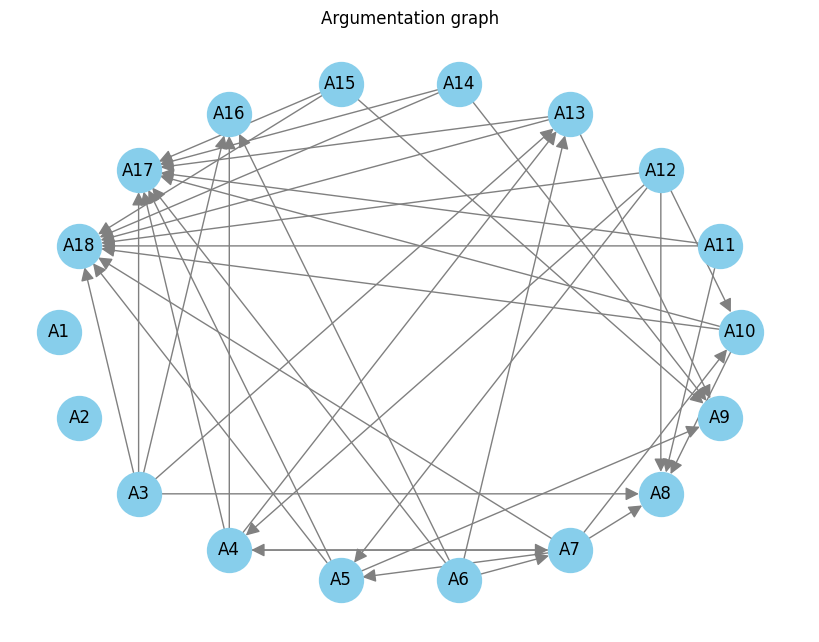

In [662]:
G = nx.DiGraph()

# Add the nodes (arguments)
argument_names = []
for argument in arguments:
    argument_names.append(argument.get_name())
G.add_nodes_from(argument_names)

# Add the edges (defeats)
G.add_edges_from(defeats)

# Viewing the graph
plt.figure(figsize=(8, 6))
pos = nx.shell_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='skyblue', font_size=12, arrowsize=20, linewidths=1, edge_color='gray', arrows=True)

plt.title("Argumentation graph")
plt.show()

Function which gives the number of defeats received by the arguments :

In [663]:
def degree_of_defeat(arguments,defeats):
    degree_of_defeat = {}
    for argument in arguments:
        number_defeats = 0
        for i, _ in enumerate(defeats):
            if defeats[i][1] == argument.get_name():
                number_defeats += 1
        degree_of_defeat[argument.get_name()] = number_defeats
        
    return degree_of_defeat

Drawing of the histogram representing the number of defeats received by the arguments :

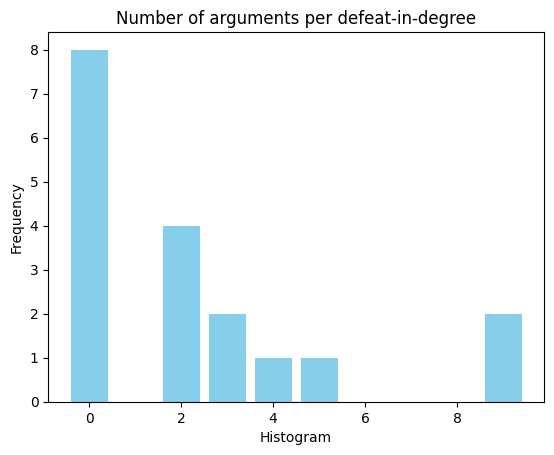

In [664]:
degree_of_defeat = degree_of_defeat(arguments,defeats)

arg_per_defeat = {}
for argument in degree_of_defeat:
    if degree_of_defeat[argument] in arg_per_defeat:
        arg_per_defeat[degree_of_defeat[argument]] += 1
    else:
        arg_per_defeat[degree_of_defeat[argument]] = 1

# Separation of data into lists for x-axis and y-axis
x = list(arg_per_defeat.keys())
y = list(arg_per_defeat.values())

# Creating and displaying the histogram
plt.bar(x, y, color='skyblue')
plt.title('Number of arguments per defeat-in-degree')
plt.xlabel('Histogram')
plt.ylabel('Frequency')
plt.show()

Function used to calculate the burden number for each argument :

In [665]:
def get_burdern_number(arguments, defeats, steps):
    burden_number = {}
    # We calculate the burden number for each argument for the number of steps
    for i in range(0, steps):
        for argument in arguments:
            # If it is the first step, the burden number is 1
            if i == 0:
                burden_number[argument.get_name()] = [1]
            # Else the burden number is 1 + 1/burden_number of the defeated arguments
            else:
                bur = 1
                for defeat in defeats:
                    if defeat[1] == argument.get_name():
                        for arg in arguments:
                            if arg.get_name() == defeat[0]:
                                bur += 1/(burden_number[arg.get_name()][i - 1])
                                bur = round(bur, 4)
                burden_number[argument.get_name()].append(bur)
    
    #Print the burden number of each argument
    for burden in burden_number:
        print(burden, end=": ")
        for i in range(0, steps):
            print(burden_number[burden][i], end=" ")
        print()
        
    return burden_number

burden_number = get_burdern_number(arguments, defeats, 10)

A1: 1 1 1 1 1 1 1 1 1 1 
A2: 1 1 1 1 1 1 1 1 1 1 
A3: 1 1 1 1 1 1 1 1 1 1 
A4: 1 3.0 2.3333 2.4286 2.4118 2.4146 2.4141 2.4142 2.4142 2.4142 
A5: 1 3.0 2.3333 2.4286 2.4118 2.4146 2.4141 2.4142 2.4142 2.4142 
A6: 1 1 1 1 1 1 1 1 1 1 
A7: 1 3.0 2.3333 2.4286 2.4118 2.4146 2.4141 2.4142 2.4142 2.4142 
A8: 1 6.0 4.6666 4.8572 4.8236 4.8292 4.8282 4.8284 4.8284 4.8284 
A9: 1 5.0 3.5833 3.7286 3.7035 3.7077 3.707 3.7071 3.7071 3.7071 
A10: 1 3.0 2.3333 2.4286 2.4118 2.4146 2.4141 2.4142 2.4142 2.4142 
A11: 1 1 1 1 1 1 1 1 1 1 
A12: 1 1 1 1 1 1 1 1 1 1 
A13: 1 4.0 3.3333 3.4286 3.4118 3.4146 3.4141 3.4142 3.4142 3.4142 
A14: 1 1 1 1 1 1 1 1 1 1 
A15: 1 1 1 1 1 1 1 1 1 1 
A16: 1 4.0 3.3333 3.4286 3.4118 3.4146 3.4141 3.4142 3.4142 3.4142 
A17: 1 10.0 7.2499 7.5858 7.5271 7.5369 7.5352 7.5355 7.5355 7.5355 
A18: 1 10.0 7.2499 7.5858 7.5271 7.5369 7.5352 7.5355 7.5355 7.5355 


Function that classifies arguments using burden-based semantics:

In [666]:
def rank_arguments(arguments, burden_number):
    rank = {}
    # Get the last value of the burden number of each argument
    for argument in arguments:
        rank[argument.get_name()] = burden_number[argument.get_name()][9]
    
    # Sort the arguments by the burden number
    rank = dict(sorted(rank.items(), key=lambda item: item[1]))
    
    # Print the rank of the arguments
    for r in rank:
        if r == list(rank.keys())[0]:
            print(r, end="")
        else:
            # Check if the burden number is the same that the previous argument
            if rank[r] == rank[list(rank.keys())[list(rank.keys()).index(r) - 1]]:
                print(",", r, end="")
            else:
                print(" > " + r, end="")
        
    return rank

rank = rank_arguments(arguments, burden_number)

A1, A2, A3, A6, A11, A12, A14, A15 > A4, A5, A7, A10 > A13, A16 > A9 > A8 > A17, A18